In [16]:
!pip3 install numpy==1.22.1 matplotlib==3.8 opencv-python gtsam tqdm open3d


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gtsam
import glob
import open3d as o3d
from tqdm import tqdm

In [ ]:
# --- Parameters ---
images_path = "./images/KITTI/04/image_0/*.png"
images_path = "./images/KITTI/17/image_0/*.png"
min_features = 2000
N_FRAMES = 15

# --- Load and sort images ---
image_files = sorted(glob.glob(images_path))[:N_FRAMES]
if not image_files:
    raise RuntimeError("No images found in folder!")
print(f"Images loaded: {len(image_files)}")

# --- Initialize FAST detector ---
fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)

Images loaded: 15


In [19]:
# --- Helper: detect new features and assign IDs ---
def detect_new_features(img, existing_ids):
    global next_feature_id
    keypoints = fast.detect(img, None)
    new_pts = []
    new_ids = []
    for kp in keypoints:
        x, y = kp.pt
        new_pts.append([x, y])
        new_ids.append(next_feature_id)
        tracked_points[next_feature_id] = (x, y)
        next_feature_id += 1
    return np.array(new_pts, dtype=np.float32).reshape(-1, 1, 2), new_ids

In [20]:
# --- Tracking state ---
next_feature_id = 0  # unique ID counter
tracked_points = {}  # {id: (x,y)}
tracks_per_frame = []  # list of dicts: [{id: (x,y)}, ...]

# --- First frame ---
prev_img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
prev_pts, prev_ids = detect_new_features(prev_img, set())
tracks_per_frame.append({pid: tuple(pt.ravel()) for pid, pt in zip(prev_ids, prev_pts)})

# --- Process frames ---
for fname in tqdm(image_files[1:N_FRAMES]):
    frame = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Track previous points with optical flow
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, frame, prev_pts, None)
    status = status.flatten()

    # Keep only successfully tracked points
    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]
    good_ids = [pid for pid, st in zip(prev_ids, status) if st == 1]

    # Update positions
    for pid, pt in zip(good_ids, good_new):
        tracked_points[pid] = pt

    # If features drop below threshold, add new ones
    if  len(good_new) < min_features:
        new_pts, new_ids = detect_new_features(frame, set(good_ids))
        good_new = np.vstack([good_new.reshape(-1, 1, 2), new_pts])
        good_ids.extend(new_ids)

    # Store current frame's tracks
    tracks_per_frame.append({pid: pt.ravel() for pid, pt in zip(good_ids, good_new)})

    # Update for next frame
    prev_img = frame
    prev_pts = good_new.reshape(-1, 1, 2)
    prev_ids = good_ids


100%|██████████| 14/14 [00:00<00:00, 87.64it/s]


In [21]:
def compute_essential(tracks_per_frame, i, j, K):
    # Get correspondences by ID
    ids_i = set(tracks_per_frame[i].keys())
    ids_j = set(tracks_per_frame[j].keys())
    common_ids = list(ids_i & ids_j)  # intersection

    if len(common_ids) < 5:
        raise ValueError("Not enough matches to compute Essential matrix")

    pts1 = np.array([tracks_per_frame[i][pid] for pid in common_ids], dtype=np.float32)
    pts2 = np.array([tracks_per_frame[j][pid] for pid in common_ids], dtype=np.float32)

    # Compute essential matrix
    E, inliers = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    return E, inliers, pts1, pts2, np.array(common_ids)

In [22]:
fx, fy = 718.856, 718.856
cx, cy = 607.1928, 185.2157
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]], dtype=np.float64)

E, inliers, pts1, pts2, common_ids = compute_essential(tracks_per_frame, 0, 1, K)
print(f"Common points used: {len(common_ids)}")
print(f"E:\n{E}")

pts1 = np.asarray(pts1, dtype=np.float64).reshape(-1, 2)
pts2 = np.asarray(pts2, dtype=np.float64).reshape(-1, 2)
num_inliers, R1, t1, mask = cv2.recoverPose(E, pts1, pts2, K)

print(f"c1_R_w:\n{R1}")
print(f"c1_t_w:\n{t1}")


Common points used: 2820
E:
[[ 1.67928793e-04 -7.06841037e-01 -1.65959769e-02]
 [ 7.06816445e-01  1.89452520e-04  9.78760996e-03]
 [ 1.77416576e-02 -1.00103483e-02  1.04984818e-05]]
c1_R_w:
[[ 9.99999918e-01  2.45119847e-04 -3.21281918e-04]
 [-2.45639180e-04  9.99998662e-01 -1.61739739e-03]
 [ 3.20885032e-04  1.61747618e-03  9.99998640e-01]]
c1_t_w:
[[ 0.01416294]
 [ 0.02508702]
 [-0.99958494]]


In [23]:
# Projection matrices
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R1, t1])

# Select only inlier correspondences
inlier_mask = mask.ravel().astype(bool)
pts1_inl = pts1[inlier_mask]
pts2_inl = pts2[inlier_mask]
common_ids_inl = common_ids[inlier_mask]
print(f"Inliers: {len(common_ids_inl)}")

# Triangulate
points_h = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)

# Convert from homogeneous to 3D
points_3d_ids = common_ids_inl
points_3d = (points_h[:3] / points_h[3]).T

Inliers: 2221


In [24]:
def register_frame_pnp(tracks_per_frame, frame_idx, points_3d, point_ids, K):
    # Build 3D-2D correspondences
    pts3d = []
    pts2d = []
    for pid, X in zip(point_ids, points_3d):
        if pid in tracks_per_frame[frame_idx]:
            pts3d.append(X)
            pts2d.append(tracks_per_frame[frame_idx][pid])
    if len(pts3d) < 6:
        raise ValueError(f"Frame {frame_idx}: not enough 2D-3D matches for PnP")

    pts3d = np.array(pts3d, dtype=np.float64)
    pts2d = np.array(pts2d, dtype=np.float64)

    # Solve PnP with RANSAC
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, distCoeffs=None,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if not success:
        raise RuntimeError(f"PnP failed for frame {frame_idx}")

    # Convert to rotation matrix
    R, _ = cv2.Rodrigues(rvec)
    t = tvec.ravel()

    return R, t, inliers

In [25]:
initial_poses = [(np.identity(3), np.zeros((3, 1))), (R1, t1)]

for idx in tqdm(range(2, N_FRAMES)):
    R, t, inliers = register_frame_pnp(
        tracks_per_frame, idx, points_3d, points_3d_ids, K
    )
    initial_poses.append((R, t))
    print(f"Registered frame {idx} inliers {len(inliers)}")
    # print(f"c{idx}_R_W:\n {R} \n c{idx}_t_W: {t}")

100%|██████████| 13/13 [00:00<00:00, 299.84it/s]

Registered frame 2 inliers 1886
Registered frame 3 inliers 1646
Registered frame 4 inliers 1426
Registered frame 5 inliers 1297
Registered frame 6 inliers 1141
Registered frame 7 inliers 1075
Registered frame 8 inliers 965
Registered frame 9 inliers 828
Registered frame 10 inliers 695
Registered frame 11 inliers 576
Registered frame 12 inliers 326
Registered frame 13 inliers 232
Registered frame 14 inliers 215


In [26]:
graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()
cal = gtsam.Cal3_S2(fx, fy, 0, cx, cy)

# Build robust noise model: Robust(Cauchy, Isotropic(sigma)) ---
base_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1)
cauchy_mest = gtsam.noiseModel.mEstimator.Cauchy(3)
robust_noise = gtsam.noiseModel.Robust(cauchy_mest, base_noise)

# Insert poses
camera_ids = []
for idx, pose in enumerate(initial_poses):
  cam_sym = gtsam.symbol('c', idx)
  cam_pose = gtsam.Pose3(gtsam.Rot3(pose[0]), pose[1]).inverse()
  initial_values.insert(cam_sym, cam_pose)
  camera_ids.append(cam_sym)

# Add a prior on the first pose to fix scale/pose gauge ---
pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6]*6))  # strong prior
cam_sym = gtsam.symbol('c', 0)
graph.add(gtsam.PriorFactorPose3(cam_sym, gtsam.Pose3(), pose_prior_noise))

points_ids = []
for point_idx, point in zip(points_3d_ids, points_3d):
  # Check if 3d points is seen in at least 3 images
  observations = [(img_idx, pts[point_idx]) for img_idx, pts in enumerate(tracks_per_frame) if point_idx in pts]
  if len(observations) < 3:
    continue

  # Add point symbol
  point_sym = gtsam.symbol('p', point_idx)
  initial_values.insert(point_sym, point)
  points_ids.append(point_sym)

  # Add reprojection factors
  for img_idx, point_2d in observations:
    measured = gtsam.Point2(point_2d[0], point_2d[1])
    cam_sym = gtsam.symbol('c', img_idx)
    proj_factor = gtsam.GenericProjectionFactorCal3_S2(measured, robust_noise, cam_sym, point_sym, cal)
    graph.add(proj_factor)

print(f"Total points inserted {len(points_ids)}")

Total points inserted 2147


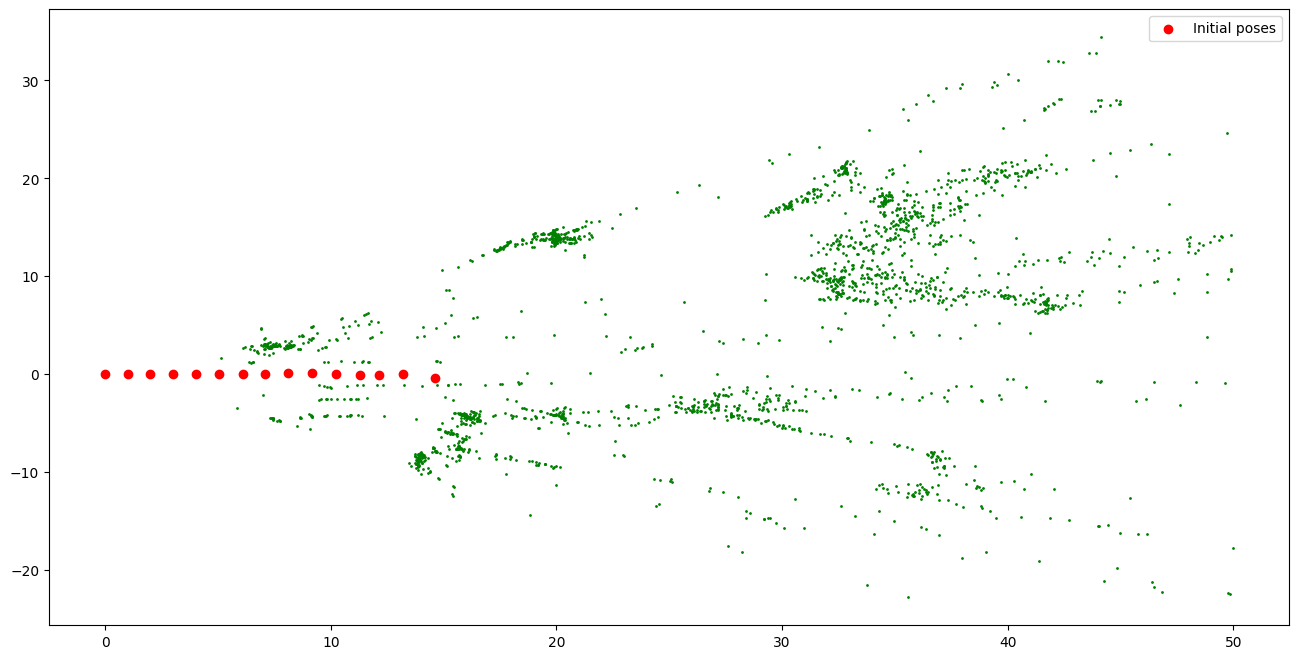

In [27]:
initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0]))
initial_poses = np.array(initial_poses)

points = []
for point_sym in points_ids:
    point = initial_values.atPoint3(point_sym)
    points.append((point[2], -point[0]))
points = np.array(points)

plt.figure(figsize=(16,8))
plt.scatter(points[:, 0], points[:, 1], c='green', s=1)
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.legend()

In [28]:
# Optimize
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setVerbosityLM("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params)
result = optimizer.optimize()
optimizer.print()

LevenbergMarquardtOptimizer
converged
errorThreshold: 84930.422836 <? 0
absoluteDecrease: 0.525582539616 <? 1e-05
relativeDecrease: 6.18835123595e-06 <? 1e-05
iterations: 54 >? 100
  parameters:

relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: TERMINATION
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: TERMINATION


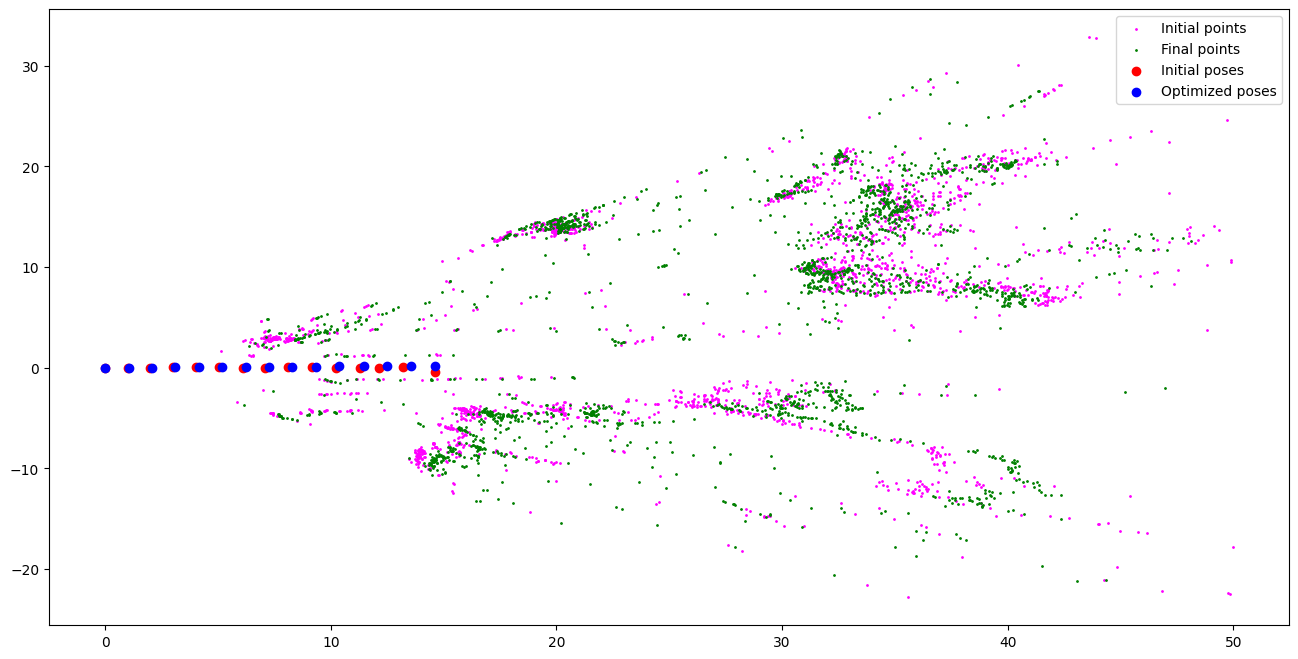

In [29]:
# Keep same scale factor of initial poses
scale = np.linalg.norm(initial_values.atPose3(camera_ids[-1]).translation()) / np.linalg.norm(result.atPose3(camera_ids[-1]).translation())

initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0]))

  pose_final = result.atPose3(cam_sym)
  final_poses.append((scale*pose_final.translation()[2], -scale*pose_final.translation()[0]))

initial_poses = np.array(initial_poses)
final_poses = np.array(final_poses)


initial_points = []
points = []
for point_sym in points_ids:
    point_initial = initial_values.atPoint3(point_sym)
    point_final = result.atPoint3(point_sym)
    if np.linalg.norm(point_final) > 50/scale or point_final[2] < 0:
      continue
    initial_points.append((point_initial[2], -point_initial[0]))
    points.append((scale*point_final[2], -scale*point_final[0]))
initial_points = np.array(initial_points)
points = np.array(points)

plt.figure(figsize=(16,8))
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='magenta', s=1, label='Initial points')
plt.scatter(points[:, 0], points[:, 1], c='green', s=1, label='Final points')
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.scatter(final_poses[:, 0], final_poses[:, 1], c='blue', label='Optimized poses')
plt.legend()


In [30]:
def gtsam_result_to_open3d(result, pose_keys_prefix='c', point_keys_prefix='p'):
    geometries = []

    # --- Collect 3D points ---
    pts = []
    for key in result.keys():
        ch = chr(gtsam.Symbol(key).chr())
        if ch == point_keys_prefix:
            pt = result.atPoint3(key)
            if np.linalg.norm(pt) > 100/scale or pt[2] < 0:
                continue
            pts.append([pt[0]*scale, pt[1]*scale, pt[2]*scale])
    if pts:
        pts_np = np.array(pts)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts_np)
        pcd.paint_uniform_color([0.1, 0.7, 0.1])  # green points
        geometries.append(pcd)

    # --- Collect camera poses as coordinate frames ---
    for key in result.keys():
        ch = chr(gtsam.Symbol(key).chr())
        if ch == pose_keys_prefix:
            pose = result.atPose3(key)
            T = pose.matrix()
            T[0:3, 3] *= scale
            frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
            frame.transform(T)   # apply pose transform
            geometries.append(frame)

    return geometries
geometries = gtsam_result_to_open3d(result)
o3d.visualization.draw_geometries(geometries, )